### T51 Capstone Project V - PCA Report of Arrests made within the US

Import required libraries 

In [55]:
# Import required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize

from sklearn.decomposition import PCA 
from pca import pca



from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc
from sklearn.neighbors import KNeighborsClassifier

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

# Ignoring OMP thread count with k-means
import warnings
warnings.filterwarnings('ignore')


### Data Exploration

Load in the dataset USArrests.csv

In [3]:
# Load dataset

df = pd.read_csv('UsArrests.csv')
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [4]:
# Understanding the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


What we find here is that within the dataframe we have 5 features. The data is described as containing statistics of the number of arrests made per 100 000 residents for 3 types of crimes (Murder, assault and rape) within each of the 50 states.

The objective of our report is to use PCA and hierarchical clustering to represent how each crime attributes itself to each state. We can therefore impose segregation on our data as being the response variable, while crime and population are our predictor variables.

This allows us to convert all predictor variables to the same datatype for convenience sake.

In [5]:
# Convert City column name to State
df.rename(columns={'City': 'State'}, inplace=True)

# Make numerical features all float types
df["Assault"] = df["Assault"].astype("float64")
df["UrbanPop"] = df["UrbanPop"].astype("float64")
df.dtypes

State        object
Murder      float64
Assault     float64
UrbanPop    float64
Rape        float64
dtype: object

In [6]:
# Check for missing values contained in the Dataframe
print('Calculating any missing values contained in the Dataframe: \n',df.isnull().sum())

Calculating any missing values contained in the Dataframe: 
 State       0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64


In [7]:
# Perform a statistical summary of our dataset
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


When perfomring a PCA report, one must always keep in mind how each feature correlates with one another. This is important as it gives insight as to how dimensionality reduction works.

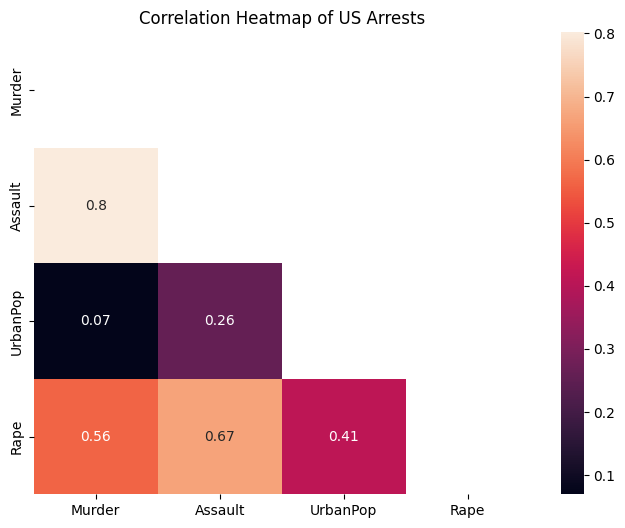

In [8]:
# Look at how our datas' features correlate with each other

plt.figure(figsize=(8,6))
Arrest_corr = df.corr()

# Mask mirrored side of heatmap
dropmirror = np.zeros_like(Arrest_corr)
dropmirror[np.triu_indices_from(dropmirror)] = True

# Create heat map visualisation
sns.heatmap(Arrest_corr, annot=True, mask=dropmirror)
plt.title('Correlation Heatmap of US Arrests')
plt.show()

Understanding the distribution of our data is a vital aspect to producing accurate reports. We know, based on the descriptive statistical analysis done, that our data contains certian features that have either a large or small range of values. The features are also quite difficult to make comparisions as UrbanPop is a percentage value representing population of residents within each state, while number of murders, rapes and assaults are all distinct numeric values that are not denoted as percentages.

We can further investigate this assumption by plotting how each feature has been distributed.

I will use a boxplot to represent the distribution.

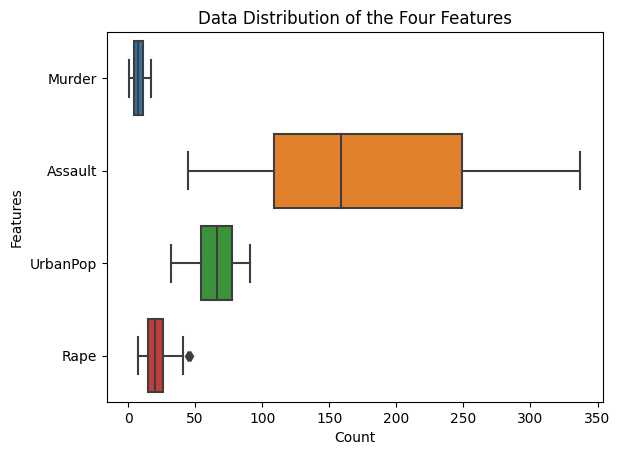

In [9]:
# Create a boxplot for feature distributions

sns.boxplot(data=df, orient='h')
plt.ylabel('Features')
plt.xlabel('Count')
plt.title('Data Distribution of the Four Features')
plt.show()

### Data Scaling

In order to get an accurate analysis of our data, we need to ensure that each feature is found within the same range of values. We therefore need to scale our data appropriately.

In [10]:
# Select independent and standardise features

scaled = StandardScaler().fit_transform(df.iloc[:,1:5])

# Create scaled version of dataset

df_scale = pd.DataFrame(scaled, columns = df.columns[1:5])
df_scale.head()

,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


PCA allows us to select componants within our dataset to describe what is actually happening. A standard form dataframe contains all features, whereas PCA selects principal components that attribute the greatest factor in determining a desired outcome.

Typically we look for a variance factor between 80% and 99% for our components. The absolute minimum threshold for variance should not be below 60%. This opens up to biased and unreliable data. We are able to easily identify the minimum number of components needed to reach this threshold by utilising scikit-learn.

In [11]:
# Show how each component sttributes itself to the explained variance

pca = PCA().fit(df_scale)
pca.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

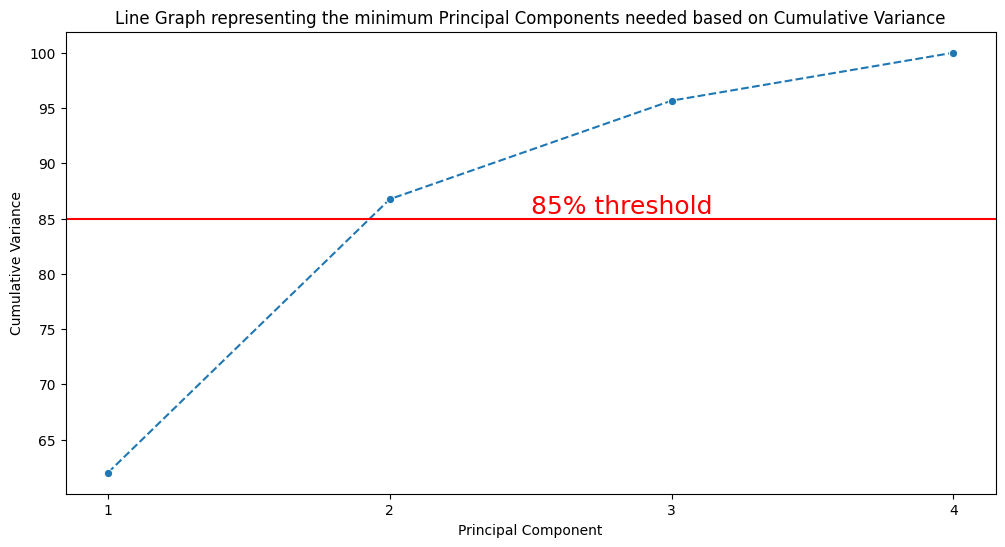

In [12]:
# Create a graph to show the minmum number of components needed for our analysis

X = np.arange(1, 5, step=1)

plt.figure(figsize=(12,6))
sns.lineplot(x=X, y=np.cumsum(pca.explained_variance_ratio_)*100, linestyle='--', marker='o')

plt.title('Line Graph representing the minimum Principal Components needed based on Cumulative Variance')
plt.xlabel('Principal Component')
plt.xticks(np.arange(1, 5, step=1))
plt.ylabel('Cumulative Variance')
plt.axhline(y=85, color='r', linestyle='-')
plt.text(2.5, 85.5, '85% threshold', color = 'red', fontsize=18)
plt.show()

This indicates that we need to use at least 2 principle components in our analysis. Component 1 contains 62% of all explained variances in our dataset. Component 2 contains 24.74% of all explained variances. Adding this up, we find that with 2 principle components, we achieve an explantion of variance within our data of 86.74%. What this means is that we effectively got rid of 50% of our data, yet we are still able to maintain an 86.74% explanation value as to how our features deviate or affect one another.

We can then proceed with our analysis and woork with two components.

In [13]:
# Proceed with 2 components

pca = PCA(n_components=2)

PC = pca.fit_transform(df_scale)

PC.shape


(50, 2)

In [14]:
# Transform components into a pands dataframe

PC_df = pd.DataFrame(data=PC, columns=['Principal Component 1', 'Principal Component 2'])
PC_df['State'] = df["State"]
PC_df.head()

,Principal Component 1,Principal Component 2,State
0,0.985566,1.133392,Alabama
1,1.950138,1.073213,Alaska
2,1.763164,-0.745957,Arizona
3,-0.141420,1.119797,Arkansas
4,2.523980,-1.542934,California


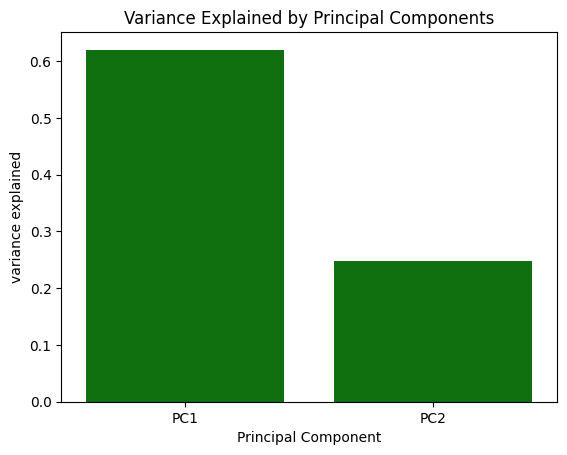

In [15]:
# Create a barplot to represent how each component affects the variance

df = pd.DataFrame({'variance explained': pca.explained_variance_ratio_, 'Principal Component': ['PC1', 'PC2']})

plt.title('Variance Explained by Principal Components')
sns.barplot(x='Principal Component', y='variance explained', data=df, color='g')
plt.show()

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.


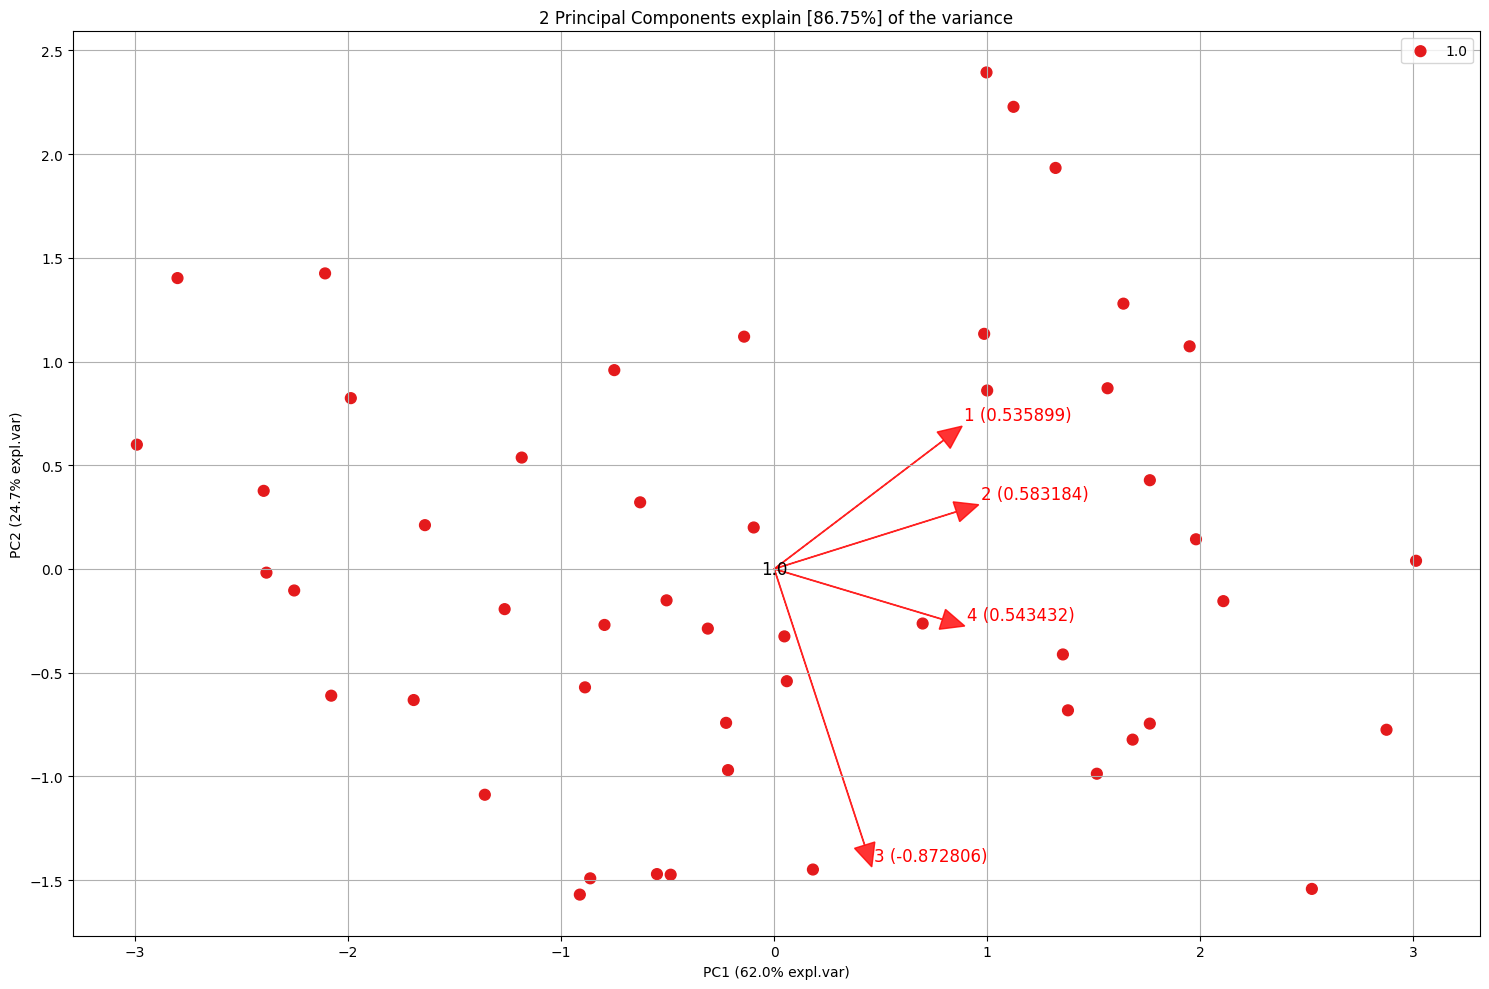

In [47]:
# Create biplot to represent components within the total DataFrame

model = pca(n_components=2)
results = model.fit_transform(scaled)

# Make biplot with the total number of features

fig, ax = model.biplot(n_feat=4, )

### Cluster Analysis

We will perform both Hierarchical Clustering and K-means with this data and compare the results.

### K-Means Analysis

K-means finds observations that share important characteristics and classifies them together into clusters. In order for K-means to achieve optimum accuracy, we need to determine the number of clusters needed for our data. We can do that by implementing what's called the K-means elbow method. The elbow method runs k-means clustering on the dataset for a range of values for k (say from 1-10) and then for each value of k computes an average score for all clusters.

In [49]:
PC_df.head()

,Principal Component 1,Principal Component 2,State
0,0.985566,1.133392,Alabama
1,1.950138,1.073213,Alaska
2,1.763164,-0.745957,Arizona
3,-0.141420,1.119797,Arkansas
4,2.523980,-1.542934,California


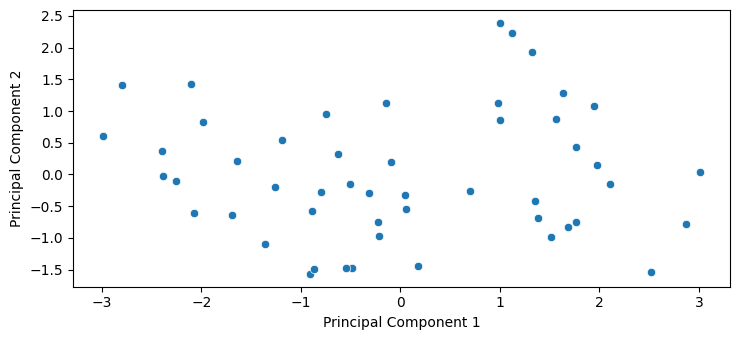

In [54]:
# Create scatterplot of principal components to investigate clustering
sns.scatterplot(data = PC_df, x = PC_df['Principal Component 1'], y = PC_df['Principal Component 2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [56]:
# Selecting features
X = PC_df[['Principal Component 1', 'Principal Component 2']]
y = PC_df['State']

# Building model with k=3
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X, y)

# Model accuracy
accuracy = knn.score(X, y)
print("Accuracy: ",accuracy)

Accuracy:  0.5


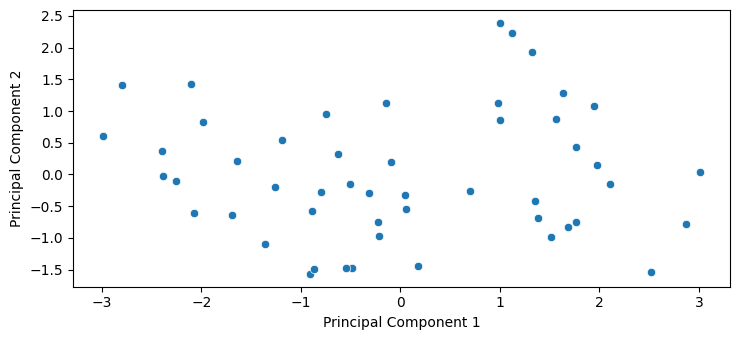

In [58]:
# Predicting the clusters
y_pred = knn.predict(X)

# Scatter plot of predicted clusters using seaborn
sns.scatterplot(x=PC_df['Principal Component 1'], y=PC_df['Principal Component 2'], data=X)
plt.show()

With the above k-means clustering, we see a moderate level of accuracy. This could be due to using only the first two principle components to plot and investigate.

### Hierarchical Clustering

First, using the principal components identified in the PCA, I will plot these into dendrograms with single, average and complex linkage to see which gives us a clearer idea of clustering.

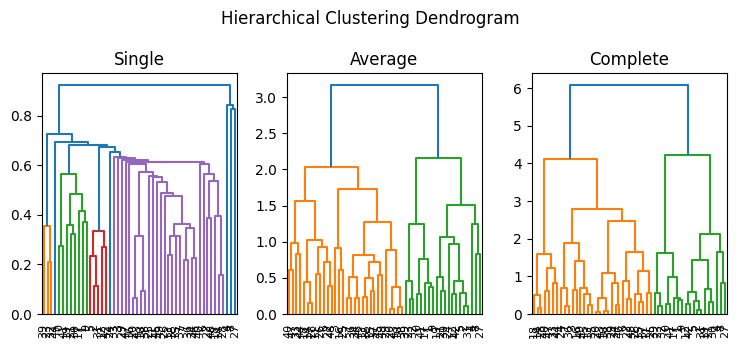

In [34]:
# Create three dendrograms with different linkage types and euclidean metrics
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(PC)


plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(PC, method='single', metric='euclidean'), ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(PC, method='average', metric='euclidean'), ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(PC, method='complete', metric='euclidean'), ax=ax3)
plt.show()

Now I will plot the same variables but changing the metric for cityblock to see the difference.

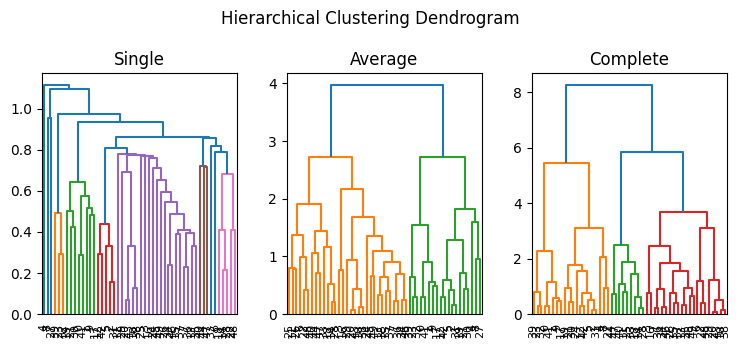

In [35]:
# Create three dendrograms with different linkage types and cityblock metrics
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(PC)


plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(PC, method='single', metric='cityblock'), ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(PC, method='average', metric='cityblock'), ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(PC, method='complete', metric='cityblock'), ax=ax3)
plt.show()

I am going to choose the complete linkage with the euclidean metrics dendrogram to go forward with and perform futher analysis.

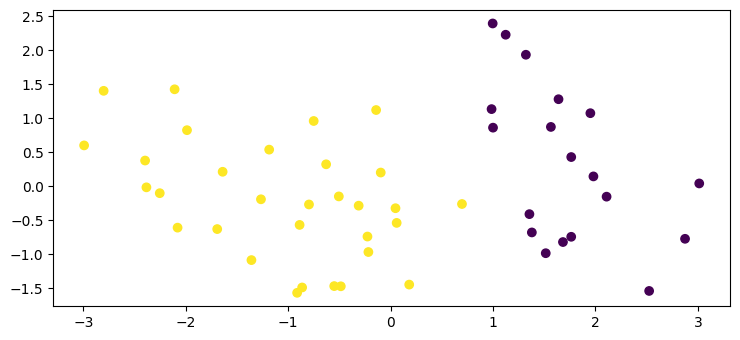

In [40]:
# agglomerative hierachical clustering with complete linkage and euclidean metrics
L = 'complete'
K = 2
cluster = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage=L)
cluster.fit_predict(PC)
plt.scatter(PC[:,0], PC[:,1], c=cluster.labels_)

I'm also including a version of a scatterplot with cityblock metrics as representative of 3 clusters.

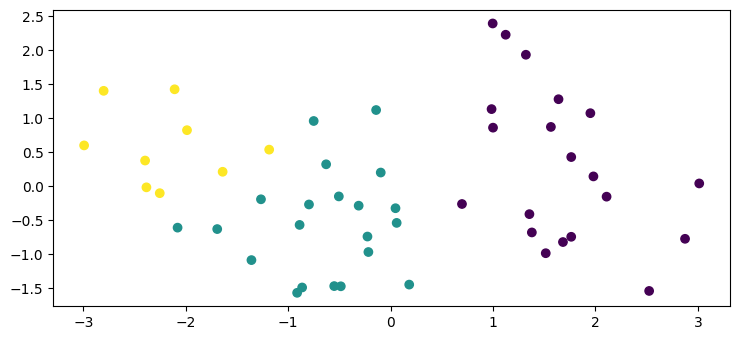

In [44]:
# agglomerative hierachical clustering with complete linkage and euclidean metrics
L = 'complete'
K = 3
cluster = AgglomerativeClustering(n_clusters=K, affinity='cityblock', linkage=L)
cluster.fit_predict(PC)
plt.scatter(PC[:,0], PC[:,1], c=cluster.labels_)

In [41]:
# Silhouette score of above linkage and metrics
score = silhouette_score(PC, labels=cluster.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.470


In [46]:
# Silhouette score of above linkage and metrics
score = silhouette_score(PC, labels=cluster.labels_, metric='cityblock')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.418


The silhouette score of the euclidean metrics version is higher than the cityblock metrics but still not a particularly high score.

A silhouette score of 0.470 on the US Arrests dataset means that the clustering of the data is of moderate quality. The score indicates that the data points in each cluster are similar to each other and different from the data points in the other clusters. However, it also suggests that there may be some overlap or ambiguity between the clusters, and some data points may not be perfectly matched to a single cluster.

It's important to note that the silhouette score is sensitive to the number of clusters, and it is always better to try different numbers of clusters and evaluate the results. Additionally, the silhouette score is sensitive to the scale of the data, if the data is not scaled the score might not be accurate.